In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import json, gensim, sklearn, pickle, sys, re, os
import IPython.display as ipd
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string
from gensim.models.phrases import Phrases
from gensim.parsing.preprocessing import strip_tags, strip_short, strip_multiple_whitespaces, stem_text
from gensim.parsing.preprocessing import remove_stopwords
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile
from gensim import utils
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from IPython.display import Audio
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
sound_file = './Music/invalid_keypress.mp3'

In [2]:
datapd=pd.read_json("arxiv-metadata-oai-snapshot.json", lines=True)

In [3]:
datapd_hep_th = datapd.loc[datapd['categories'].str.contains('hep-th')]
hep_abstracts = datapd_hep_th[ list(datapd_hep_th.iloc[:,0:1]) + ['abstract'] + ['title']]
hep_abstracts_limit=hep_abstracts[hep_abstracts.title.str.count(' ') < 15]

In [4]:
hep_corpus_limit=hep_abstracts_limit['abstract'].values 
hep_corpus_limit_eof=hep_corpus_limit+" EOF"
short_hep_abs=hep_corpus_limit_eof

In [5]:
hep_abstracts.shape

(140500, 3)

In [6]:
short_hep_abs.shape

(134296,)

In [7]:
hep_titles=hep_abstracts_limit['title'].values
hep_titles_eof=hep_titles + " EOF"
short_hep_tit=hep_titles_eof

### By doing the above, we have obtained the 130K papers that belong in high energy theory physics (hep-th) ###

### We restrict to papers that are not longer than 16 words. We also add an " EOF" to indicate the end of the abstract/title ###

## We will now process the documents using gensim. This removes stop words, punctuations, capitalization and stems and lemmatizes the tezt ##

In [8]:
doc_tokenized_nostop=preprocess_documents(short_hep_abs)

In [9]:
doctitle_tokenized_nostop=preprocess_documents(short_hep_tit)

In [10]:
leabs = [len(x) for x in doc_tokenized_nostop]
letit = [len(x) for x in doctitle_tokenized_nostop]

In [11]:
count=0
for x in range(len(leabs)):
    if leabs[x]>155:
        count=count+1
print(count)

729


In [12]:
count=0
for x in range(len(letit)):
    if letit[x]>12:
        count=count+1
        #print(x)
print(count)

755


### The above tells us that less than 0.5% of the papers have abstracts longer than 155 words or titles longer than 12 words. We will use this fact below when constructing our LSTM network ###

In [13]:
print(max(letit),max(leabs))

18 199


In [14]:
print(len(short_hep_abs),len(doctitle_tokenized_nostop),len(doc_tokenized_nostop))

134296 134296 134296


In [15]:
doc_tokenized_nostop[225]

['argu',
 'tachyon',
 'free',
 'type',
 'string',
 'vacua',
 'supersymmetri',
 'break',
 'open',
 'sector',
 'string',
 'scale',
 'interpret',
 'dualiti',
 'argument',
 'metast',
 'vacua',
 'supersymmetr',
 'type',
 'superstr',
 'dynam',
 'process',
 'partial',
 'captur',
 'nucleat',
 'brane',
 'antibran',
 'pair',
 'non',
 'supersymmetr',
 'vacuum',
 'subsequ',
 'tachyon',
 'condens',
 'eof']

In [16]:
doctitle_tokenized_nostop[225]

['metast', 'string', 'vacua', 'eof']

In [17]:
vec_size=52

## Below we train Word2Vec. This will learn word embeddings ## 

In [18]:
short_hepmodel=Word2Vec(sentences=doc_tokenized_nostop,size=vec_size, window=5, min_count=1, workers=4, iter=5)

In [19]:
totalvocab=len(short_hepmodel.wv.vocab)
print(totalvocab)

34969


In [20]:
short_hepmodel.build_vocab(doctitle_tokenized_nostop, update=True)
short_hepmodel.train(doctitle_tokenized_nostop, total_examples=short_hepmodel.corpus_count, epochs=2)

(1417709, 1884064)

In [21]:
totalvocab=len(short_hepmodel.wv.vocab)
print(totalvocab)

35853


In [22]:
#pickle.dump(short_hepmodel,open("Modelsfeb18/hepmodel_feb_26_1558", 'wb'))
#short_hepmodel=pickle.load(open('ModelsFeb23/hepmodel_feb_26_1558','rb'))

# Visualising using t-SNE #

In [23]:
def tsnescatterplot(model, word):
    
    arr = np.empty((0,vec_size), dtype='f')
    word_labels = [word]

    close_words = model.wv.similar_by_word(word,topn=15)
    

    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        

    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 5), textcoords='offset points')
    plt.xlim(x_coords.min()-15, x_coords.max()+15)
    plt.ylim(y_coords.min()-15, y_coords.max()+15)
    plt.show()

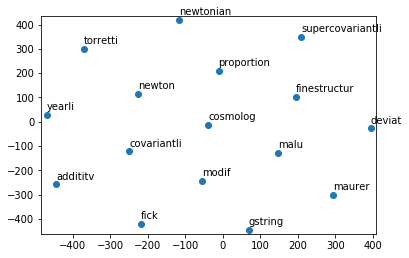

In [24]:
tsnescatterplot(short_hepmodel, 'newton')

In [25]:
short_hepmodel.wv.most_similar(positive=["newton"],topn=15)

[('proportion', 0.5625348091125488),
 ('torretti', 0.5618959069252014),
 ('newtonian', 0.5581762194633484),
 ('cosmolog', 0.5256727337837219),
 ('yearli', 0.5224730968475342),
 ('deviat', 0.522132396697998),
 ('finestructur', 0.5130105018615723),
 ('addititv', 0.500487744808197),
 ('modif', 0.4972865879535675),
 ('fick', 0.49547916650772095),
 ('malu', 0.4920443892478943),
 ('covariantli', 0.4866793155670166),
 ('maurer', 0.48058149218559265),
 ('supercovariantli', 0.47930726408958435),
 ('gstring', 0.47904014587402344)]

# Now we will train an LSTM network with attention to get better word embeddings #

## The aim of the task is to predict paper titles from the abstract. This is an impossibly hard task, but hopefully we will learn good word emebeddings along the way ##

In [26]:
#!pip install keras  
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras.layers.embeddings import Embedding
import keras.backend as K

## Setting max length of the abstract and title to be 155 and 12 respectively. As shown above this is a reasonable thing to do ##

In [27]:
Tx=155
Ty=12

### The below function takes in sentences, and out puts a list of numbers. Each number correspond to a word. Thus the range of the numbers is from 0 to length of the vocab.  ###

In [28]:
def sentences_to_indices(X, hepmodel,max_len):
    m = X.shape[0] 
    X_indices = np.zeros((m,max_len),dtype='uint16')+hepmodel.wv.vocab.get('eof').index
    for i in range(m):                          
        sentence_words = X[i]
        j = 0
        for w in sentence_words:
            X_indices[i, j] = hepmodel.wv.vocab.get(w).index
            j = j+1
            if j>=max_len:
                break
    return X_indices

In [29]:
array_abs=np.asarray(doc_tokenized_nostop)
array_tit=np.asarray(doctitle_tokenized_nostop)

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [30]:
train_X_indices=sentences_to_indices(array_abs,short_hepmodel,Tx)
train_Y_indices=sentences_to_indices(array_tit,short_hepmodel,Ty)

## The below function creates a small dense network for the attention layer ##

In [31]:
from keras.activations import softmax
def softmax_axis1(x):
    return softmax(x,axis=1)
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(Tx)
densor2 = Dense(Tx)
densor3 = Dense(10)
densor4 = Dense(1, activation = "relu")
activator = Activation(softmax_axis1, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [32]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    concat = concatenator([a,s_prev])

    e = densor1(concat)
    e = tf.keras.layers.LeakyReLU(alpha=0.3)(e)


    e = densor3(e)
    e = tf.keras.layers.LeakyReLU(alpha=0.3)(e)

    energies = densor4(e)
    alphas = activator(energies)
    context = dotor([alphas,a])
    
    return context

In [33]:
X1 = np.array([['witten', 'unif', 'string', 'theori' ],['dirac', 'discover', 'field' , 'theori']])
X1_indices = sentences_to_indices(X1, short_hepmodel,max_len = Tx)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = [['witten' 'unif' 'string' 'theori']
 ['dirac' 'discover' 'field' 'theori']]
X1_indices =
 [[  426   969    10     0     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1
      1     1   

## Now let's set up the LSTM network ##

In [34]:
n_a = 64 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

post_activation_LSTM_cell = LSTM(n_s, return_state = True) 
output_layer = Dense(totalvocab, activation=softmax_axis1)

## We initialize the vectors to be small random vectors. We *Do Not* initialize it with the Word2Vec vectors that we obtained above ##

## We found that when initialized with Word2Vec the LSTM training changes the word vectors by less than 5%. In other words the vectors are stuck near a local minima.  ##

## If we initialize them randomly. The final vectors are very different from the initialized random vectors, and subsequently these new final vectors encode meaning differently ##

# As mentioned in the report, Word2Vec is good at encoding words that are related *and* that appear together. While LSTM is good at encoding words that are related *but* do not appear together. 

In [35]:
small_pre=(2*np.random.rand(totalvocab, vec_size)-1)*0.01
small_vectors=small_pre*short_hepmodel.wv.vectors
appker=np.zeros((1,vec_size))
kerasvectors=np.vstack((small_vectors,appker))

## Define the embedding layer and set *trainable=True*. We will read the weights from this layer once the network has trained. ##

In [36]:
def pretrained_embedding_layer(hepmodel):
    vocab_len = totalvocab + 1                  
    emb_dim = hepmodel.wv["newton"].shape[0]      
    emb_matrix = np.zeros((vocab_len,emb_dim))
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=True)
    embedding_layer.build((None,)) 
    embedding_layer.set_weights([kerasvectors])
    
    return embedding_layer

In [37]:
embedding_layer = pretrained_embedding_layer(short_hepmodel)
print("weights[0][1628][12] =", embedding_layer.get_weights()[0][1628][12])

weights[0][1628][12] = -9.339144e-05


In [38]:
train_Y_indices

array([[  83,  491,   63, ...,    1,    1,    1],
       [4041,    4, 8213, ...,    1,    1,    1],
       [   6,    2,    0, ...,    1,    1,    1],
       ...,
       [3399,  955,  541, ...,    1,    1,    1],
       [ 158, 3117,  541, ...,   91,    1,    1],
       [  10,    3, 2707, ...,    1,    1,    1]], dtype=uint16)

## Define the model. Two bi-directional LSTMs --> Attention layer ---> LSTM ----> Softmax. The output is (Ty) number of column vectors of dimension (totalvocab).

In [39]:
def kerasmagic(input_shape, Tx, Ty, n_a, n_s, totalvocab, hepmodel): 
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer 
    embedding_layer = pretrained_embedding_layer(hepmodel)
    embeddings = embedding_layer(sentence_indices)
    
    
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(embeddings)
    b = Bidirectional(LSTM(units=n_a, return_sequences=True))(a)
    
    #b = Bidirectional(LSTM(units=n_a))(b)
        
    for t in range(Ty):
    
        # Perform one step of the attention mechanism #
        context = one_step_attention(b,s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        s, _ , c = post_activation_LSTM_cell(context, initial_state=[s,c])
        out = output_layer(s)
        outputs.append(out)
    
    model = Model([sentence_indices,s0,c0],outputs)
    
    return model

In [40]:
kerasmodel=kerasmagic(Tx,Tx,Ty,n_a,n_s,totalvocab,short_hepmodel)

In [41]:
kerasmodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 155)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 155, 52)      1864408     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 155, 128)     59904       embedding_1[0][0]                
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
______________________________________________________________________________________________

In [42]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.0)
kerasmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
short_hepmodel.wv.index2word[0]

'theori'

In [44]:
print(train_X_indices.size*train_X_indices.itemsize)
print(train_Y_indices.size*train_Y_indices.itemsize)

41631760
3223104


### echo 1 | sudo tee /proc/sys/vm/overcommit_memory ###

In [45]:
vocab_size = totalvocab
text_length = len(train_Y_indices[0])
one_hot = np.zeros([train_X_indices.shape[0],vocab_size,text_length],dtype='uint16')

In [46]:
for i in range(train_X_indices.shape[0]):
    for j in range(Ty):
        one_hot[i,train_Y_indices[i,j],j]=1

In [47]:
listhot = list(one_hot.T.swapaxes(1,2))

In [48]:
one_hot.shape
print(train_X_indices.shape)
print(listhot[7].shape)

(134296, 155)
(134296, 35853)


In [62]:
def BatchGenerator(train_X_indices,one_hot):
    for i in range(1,33):
        X_train = train_X_indices[4096*(i-1):4096*i,:]
        one_hot_sliced = one_hot[4096*(i-1):4096*i,:,:]
        Y_train = list(one_hot_sliced.T.swapaxes(1,2))
        yield (X_train, Y_train)
    X_train = train_X_indices[4096*i:-1,:]
    one_hot_sliced = one_hot[4096*i:-1,:,:]
    Y_train = list(one_hot_sliced.T.swapaxes(1,2))
    yield (X_train,Y_train)

In [63]:
i=0
for (X_train,Y_train) in BatchGenerator(train_X_indices,one_hot):
    m = X_train.shape[0]
    s0 = np.zeros((m, n_s))
    c0 = np.zeros((m, n_s))
    i=i+1
    print(f" \n Metabatch number --------------------- {i} \n ")
#   print(X_train.shape,Y_train.shape)
    kerasmodel.fit([X_train, s0, c0], Y_train, epochs=1, batch_size=128)

 
 Metabatch number --------------------- 1 
 
32/32 [==============================] - 16s 488ms/step - loss: 48.5081 - dense_4_loss: 7.3711 - dense_4_1_loss: 7.6120 - dense_4_2_loss: 7.4299 - dense_4_3_loss: 6.8185 - dense_4_4_loss: 5.7455 - dense_4_5_loss: 4.4640 - dense_4_6_loss: 3.1941 - dense_4_7_loss: 2.1088 - dense_4_8_loss: 1.4206 - dense_4_9_loss: 0.9324 - dense_4_10_loss: 0.7395 - dense_4_11_loss: 0.6717 - dense_4_accuracy: 4.8828e-04 - dense_4_1_accuracy: 0.0022 - dense_4_2_accuracy: 0.0269 - dense_4_3_accuracy: 0.0957 - dense_4_4_accuracy: 0.2344 - dense_4_5_accuracy: 0.4246 - dense_4_6_accuracy: 0.6094 - dense_4_7_accuracy: 0.7725 - dense_4_8_accuracy: 0.8774 - dense_4_9_accuracy: 0.9500 - dense_4_10_accuracy: 0.9819 - dense_4_11_accuracy: 0.9929
 
 Metabatch number --------------------- 2 
 
32/32 [==============================] - 16s 486ms/step - loss: 48.5013 - dense_4_loss: 7.4147 - dense_4_1_loss: 7.6224 - dense_4_2_loss: 7.4754 - dense_4_3_loss: 6.9260 - dense_4_4_

In [75]:
new_weights = kerasmodel.layers[1].get_weights()[0]

In [76]:
#pickle.dump(new_weights,open("ModelsFeb23/weights_26_1730_6_smallinit",'wb'))

In [77]:
#neweights=kerasmodel.get_layer('embedding').get_weights()[0]
#kerasvectors[short_hepmodel.wv.vocab.get("witten").index,:]

In [78]:
def randomdistance(w1,w2): 
    num=np.dot(kerasvectors[short_hepmodel.wv.vocab.get(w1).index,:],kerasvectors[short_hepmodel.wv.vocab.get(w2).index,:])
    den1=np.dot(kerasvectors[short_hepmodel.wv.vocab.get(w1).index,:],kerasvectors[short_hepmodel.wv.vocab.get(w1).index,:])
    den2=np.dot(kerasvectors[short_hepmodel.wv.vocab.get(w2).index,:],kerasvectors[short_hepmodel.wv.vocab.get(w2).index,:])
    return num/np.sqrt(den1*den2)

In [79]:
def newdistance(w1,w2): 
    num=np.dot(new_weights[short_hepmodel.wv.vocab.get(w1).index,:],new_weights[short_hepmodel.wv.vocab.get(w2).index,:])
    den1=np.dot(new_weights[short_hepmodel.wv.vocab.get(w1).index,:],new_weights[short_hepmodel.wv.vocab.get(w1).index,:])
    den2=np.dot(new_weights[short_hepmodel.wv.vocab.get(w2).index,:],new_weights[short_hepmodel.wv.vocab.get(w2).index,:])
    return num/np.sqrt(den1*den2)

In [80]:
def olddistance(w1,w2): 
    num=np.dot(short_hepmodel.wv[w1].T,short_hepmodel.wv[w2])
    den1=np.dot(short_hepmodel.wv[w1].T,short_hepmodel.wv[w1])
    den2=np.dot(short_hepmodel.wv[w2].T,short_hepmodel.wv[w2])
    return num/np.sqrt(den1*den2)

In [81]:
short_hepmodel.wv.most_similar(positive=["graviti"],topn=15)

[('bigrav', 0.5847691297531128),
 ('mwand', 0.5196281671524048),
 ('gravit', 0.49977532029151917),
 ('tmg', 0.4800078868865967),
 ('aether', 0.46520933508872986),
 ('caliz', 0.4608544111251831),
 ('horndeski', 0.46077531576156616),
 ('maxwel', 0.45286959409713745),
 ('galileon', 0.4516640305519104),
 ('vcc', 0.4507347047328949),
 ('evera', 0.4476248621940613),
 ('rel', 0.4465886652469635),
 ('electrodynam', 0.44282782077789307),
 ('cosmolog', 0.4363742768764496),
 ('palatini', 0.43545424938201904)]

In [82]:
newdistance("graviti","newtonian")

0.9406544

In [83]:
def distance(w1,w2):
    print(f"Random distance : {randomdistance(w1,w2)} ")    
    print(f"Word2Vec distance : {olddistance(w1,w2)} ")
    print(f"Our LSTM distance : {newdistance(w1,w2)} ")

In [105]:
distance("gener","relat")

Random distance : 0.07818636634452886 
Word2Vec distance : 0.48400288820266724 
Our LSTM distance : 0.9903555512428284 


In [106]:
distance("witten","brane")

Random distance : 0.08210770744612497 
Word2Vec distance : 0.024747705087065697 
Our LSTM distance : 0.9620609879493713 


## Only testing below. No new code. ##

In [86]:
distance("hawk","blackhol")

Random distance : -0.1735790213126782 
Word2Vec distance : 0.5095011591911316 
Our LSTM distance : 0.4693949818611145 


In [87]:
distance("hawk","information")

Random distance : -0.007357943536875019 
Word2Vec distance : 0.10821077227592468 
Our LSTM distance : 0.13437694311141968 


In [88]:
distance("information","paradox")

Random distance : -0.004614738589563649 
Word2Vec distance : 0.36223238706588745 
Our LSTM distance : 0.1721714437007904 


In [89]:
distance("witten","seiberg")

Random distance : 0.056995172560698575 
Word2Vec distance : 0.3886634409427643 
Our LSTM distance : 0.9219940304756165 


In [90]:
distance("holographi","maldacena")

Random distance : -0.05183285556678813 
Word2Vec distance : 0.3954869210720062 
Our LSTM distance : 0.9247261881828308 


In [91]:
distance("witten","string")

Random distance : -0.21007742574811286 
Word2Vec distance : 0.19099871814250946 
Our LSTM distance : 0.9247686266899109 


In [92]:
distance("diagram","feynman")

Random distance : -0.3543670814664644 
Word2Vec distance : 0.3977150022983551 
Our LSTM distance : 0.7770392298698425 


In [93]:
distance("brane","witten")

Random distance : 0.08210770744612497 
Word2Vec distance : 0.024747705087065697 
Our LSTM distance : 0.9620609879493713 


In [94]:
distance("wilson","rg")

Random distance : -0.3960001742696835 
Word2Vec distance : -0.05112694203853607 
Our LSTM distance : -0.018089938908815384 


In [95]:
distance("renormaliz","quantum")

Random distance : -0.12097695160003447 
Word2Vec distance : 0.2348415106534958 
Our LSTM distance : 0.9697962999343872 


In [107]:
distance("graviti","nonrenormaliz")

Random distance : 0.13312005101571397 
Word2Vec distance : 0.30107200145721436 
Our LSTM distance : 0.3115948438644409 


In [108]:
distance("pauli","heisenberg")

Random distance : -0.08026520653807753 
Word2Vec distance : 0.2914222478866577 
Our LSTM distance : 0.8830674886703491 


In [109]:
distance("isi","fix")

Random distance : -0.007398052373150316 
Word2Vec distance : -0.36764681339263916 
Our LSTM distance : 0.0006296865758486092 


In [110]:
distance("einstein","quantum")

Random distance : -0.25965694463058264 
Word2Vec distance : 0.17695051431655884 
Our LSTM distance : 0.9747143387794495 


In [111]:
distance("graviti","quantum")

Random distance : 0.15399388292422278 
Word2Vec distance : -0.020672762766480446 
Our LSTM distance : 0.9815539121627808 


In [112]:
distance("string","graviti")

Random distance : 0.16424334228916998 
Word2Vec distance : 0.05436236783862114 
Our LSTM distance : 0.9826259016990662 


In [113]:
distance("isi","conform")

Random distance : -0.07576074264608211 
Word2Vec distance : -0.23231807351112366 
Our LSTM distance : -0.06802619248628616 


In [114]:
distance("isi","cft")

Random distance : 0.12989734355216886 
Word2Vec distance : -0.09121870994567871 
Our LSTM distance : -0.04096447303891182 


In [115]:
distance("mellin","bootstrap")

Random distance : 0.012516211692843206 
Word2Vec distance : 0.36304622888565063 
Our LSTM distance : 0.4926113784313202 


In [120]:
distance("string","theori")

Random distance : -0.14368135532280366 
Word2Vec distance : 0.15752534568309784 
Our LSTM distance : 0.9911961555480957 


In [121]:
distance("quantum","theori")

Random distance : -0.05739704625072687 
Word2Vec distance : 0.17478995025157928 
Our LSTM distance : 0.9895001649856567 


In [122]:
distance("quark","color")

Random distance : -0.21950370784678408 
Word2Vec distance : 0.6166797280311584 
Our LSTM distance : 0.9212174415588379 


In [123]:
distance("gaug","confin")

Random distance : -0.03902662731800803 
Word2Vec distance : 0.25014472007751465 
Our LSTM distance : 0.9779474139213562 


In [124]:
distance("wilson","confin")

Random distance : -0.1533657600785285 
Word2Vec distance : 0.20845641195774078 
Our LSTM distance : 0.8777956366539001 


In [125]:
distance("quark","confin")

Random distance : 0.020526790108468727 
Word2Vec distance : 0.563359260559082 
Our LSTM distance : 0.9275000095367432 


In [126]:
#pickle.dump(new_weights,open("ModelsFeb23/weights_26_1600_1_smallinit",'wb'))
#pickle.dump(short_hepmodel,open("ModelsFeb23/short_hepmodel_26_1600_1_smallinit",'wb'))

In [80]:
weights1=pickle.load(open("ModelsFeb23/weights_26_1613_1_smallinit",'rb'))
weights3=pickle.load(open("ModelsFeb23/weights_26_1630_3_smallinit",'rb'))
weights6=pickle.load(open("ModelsFeb23/weights_26_1630_6_smallinit",'rb'))
#tempmodel=pickle.load(open("ModelsFeb23/short_hepmodel_24_1957",'rb'))

In [179]:
#tempweights[tempmodel.wv.vocab.get("witten").index,:]

In [83]:
def pickledistance(w1,w2,new_weights):
    num=np.dot(new_weights[short_hepmodel.wv.vocab.get(w1).index,:],new_weights[short_hepmodel.wv.vocab.get(w2).index,:])
    den1=np.dot(new_weights[short_hepmodel.wv.vocab.get(w1).index,:],new_weights[short_hepmodel.wv.vocab.get(w1).index,:])
    den2=np.dot(new_weights[short_hepmodel.wv.vocab.get(w2).index,:],new_weights[short_hepmodel.wv.vocab.get(w2).index,:])
    newdist= num/np.sqrt(den1*den2)
    num=np.dot(short_hepmodel.wv[w1].T,short_hepmodel.wv[w2])
    den1=np.dot(short_hepmodel.wv[w1].T,short_hepmodel.wv[w1])
    den2=np.dot(short_hepmodel.wv[w2].T,short_hepmodel.wv[w2])
    olddist= num/np.sqrt(den1*den2)
    num=np.dot(kerasvectors[short_hepmodel.wv.vocab.get(w1).index,:],kerasvectors[short_hepmodel.wv.vocab.get(w2).index,:])
    den1=np.dot(kerasvectors[short_hepmodel.wv.vocab.get(w1).index,:],kerasvectors[short_hepmodel.wv.vocab.get(w1).index,:])
    den2=np.dot(kerasvectors[short_hepmodel.wv.vocab.get(w2).index,:],kerasvectors[short_hepmodel.wv.vocab.get(w2).index,:])
    rand= num/np.sqrt(den1*den2)
    print(f"Random distance : {rand} ")    
    print(f"Word2Vec distance : {olddist} ")
    print(f"Our LSTM distance : {newdist} ")

In [87]:
pickledistance("witten","brane",weights6)

Random distance : 0.0930195273435413 
Word2Vec distance : 0.040753476321697235 
Our LSTM distance : 0.371532142162323 


In [91]:
pickledistance("wilson","rg",weights6)

Random distance : 0.1161497091576768 
Word2Vec distance : -0.022293496876955032 
Our LSTM distance : 0.7281190752983093 


In [96]:
pickledistance("string","theori",weights6)

Random distance : 0.10506595089579158 
Word2Vec distance : 0.1636536419391632 
Our LSTM distance : -0.214313343167305 
